# Logistic Regression

In [1]:
import copy
import math
from typing import Callable
from typing import Tuple
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

%matplotlib inline

Determine each applicant’s chance of admission based on their results on two exams. 
* Historical data from previous applicants that you can use as a training set for logistic regression. 
* For each training example, the applicant’s scores on two exams and the admissions decision. 
* Build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. 

In [2]:
# load dataset
df = pd.read_csv("data/exam_class.csv")

X_train = df.drop("passed", axis=1).to_numpy()
y_train = df["passed"].to_numpy()


In [3]:
df.head()

,Exam1,Exam2,passed
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [4]:
X_train

array([[34.62365962, 78.02469282],
       [30.28671077, 43.89499752],
       [35.84740877, 72.90219803],
       [60.18259939, 86.3085521 ],
       [79.03273605, 75.34437644],
       [45.08327748, 56.31637178],
       [61.10666454, 96.51142588],
       [75.02474557, 46.55401354],
       [76.0987867 , 87.42056972],
       [84.43281996, 43.53339331],
       [95.86155507, 38.22527806],
       [75.01365839, 30.60326323],
       [82.30705337, 76.4819633 ],
       [69.36458876, 97.71869196],
       [39.53833914, 76.03681085],
       [53.97105215, 89.20735014],
       [69.07014406, 52.74046973],
       [67.94685548, 46.67857411],
       [70.66150955, 92.92713789],
       [76.97878373, 47.57596365],
       [67.37202755, 42.83843832],
       [89.67677575, 65.79936593],
       [50.53478829, 48.85581153],
       [34.21206098, 44.2095286 ],
       [77.92409145, 68.97235999],
       [62.27101367, 69.95445795],
       [80.19018075, 44.82162893],
       [93.1143888 , 38.80067034],
       [61.83020602,

In [5]:
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:", type(X_train))


First five elements in X_train are:
 [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
Type of X_train: <class 'numpy.ndarray'>


Now print the first five values of `y_train`

In [6]:
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:", type(y_train))


First five elements in y_train are:
 [0 0 0 1 1]
Type of y_train: <class 'numpy.ndarray'>


In [7]:
print("The shape of X_train is: " + str(X_train.shape))
print("The shape of y_train is: " + str(y_train.shape))
print("We have m = %d training examples" % (len(y_train)))


The shape of X_train is: (100, 2)
The shape of y_train is: (100,)
We have m = 100 training examples


In [8]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    plt.plot(X[positive, 0], X[positive, 1], "k+", label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], "yo", label=neg_label)


#### Visualize data

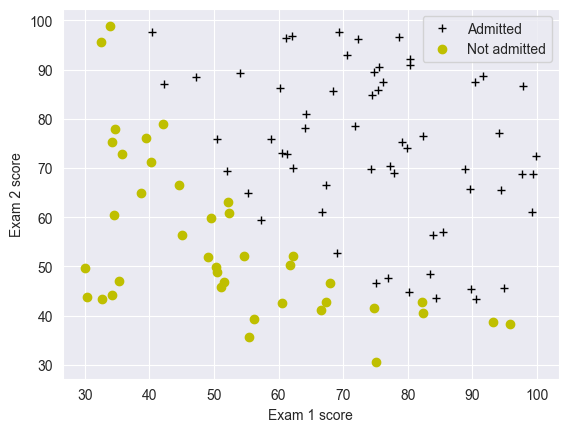

In [9]:
plot_data(X_train, y_train[:], pos_label="Admitted", neg_label="Not admitted")

plt.ylabel("Exam 2 score")
plt.xlabel("Exam 1 score")
plt.legend(loc="upper right")
plt.show()


### Sigmoid function

For logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$

Note that 
- `z` is not always a single number, but can also be an array of numbers. 
- If the input is an array of numbers, we'd like to apply the sigmoid function to each value in the input array.

In [10]:
def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Compute the sigmoid of z
    Args:
        z: A scalar, numpy array of any size.
    Returns:
        g: sigmoid(z), with the same shape as z
    """
    return 1 / (1 + np.exp(-z))

In [11]:
print("sigmoid(0) = " + str(sigmoid(0)))


sigmoid(0) = 0.5


In [12]:
print("sigmoid([ -1, 0, 1, 2]) = " + str(sigmoid(np.array([-1, 0, 1, 2]))))


sigmoid([ -1, 0, 1, 2]) = [0.26894142 0.5        0.73105858 0.88079708]


### Cost function for logistic regression

For logistic regression, the cost function is of the form 

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is - 

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.
    * It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x^{(i)}} + b = w_0x^{(i)}_0 + ... + w_{n-1}x^{(i)}_{n-1} + b$ where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$


In [13]:
def compute_cost(X: np.ndarray, y: np.array, w: np.array, b: float, lambda_: int=1) -> float:
    """
    Computes the cost over all examples
    Args:
      X: data, m examples by n features
      y: target value
      w: Values of parameters of the model
      b: scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost
    """

    m, n = X.shape
    cost = 0
    for i in range(m):
        z = np.dot(X[i], w) + b
        f_wb = sigmoid(z)
        cost += -y[i] * np.log(f_wb) - (1 - y[i]) * np.log(1 - f_wb)
    total_cost = cost / m
    return total_cost


In [14]:
m, n = X_train.shape

# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.0
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print("Cost at initial w (zeros): {:.3f}".format(cost))


Cost at initial w (zeros): 0.693


In [15]:
# Compute and display cost with non-zero w
test_w = np.array([0.2, 0.2])
test_b = -24.0
cost = compute_cost(X_train, y_train, test_w, test_b)

print("Cost at test w,b: {:.3f}".format(cost))


Cost at test w,b: 0.218


### Gradient for logistic regression


$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously


the `compute_gradient` function to compute $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label


> While this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $f_{\mathbf{w},b}(x)$.


In [16]:
def compute_gradient(
    X: np.ndarray, y: np.array, w: np.array, b: float, lambda_=None
) -> Tuple[float, float]:
    """
    Computes the gradient for logistic regression

    Args:
      X: variable such as house size
      y: actual value
      w: values of parameters of the model
      b: value of parameter of the model
      lambda_: unused placeholder.
    Returns
      dj_dw: The gradient of the cost w.r.t. the parameters w.
      dj_db: The gradient of the cost w.r.t. the parameter b.
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.0

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i], w) + b)
        err_i = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i, j]
        dj_db = dj_db + err_i
    dj_dw = dj_dw / m
    dj_db = dj_db / m
    return dj_db, dj_dw


In [17]:
# Compute and display gradient with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.0

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f"dj_db at initial w (zeros):{dj_db}")
print(f"dj_dw at initial w (zeros):{dj_dw.tolist()}")


dj_db at initial w (zeros):-0.1
dj_dw at initial w (zeros):[-12.00921658929115, -11.262842205513591]


In [18]:
# Compute and display cost and gradient with non-zero w
test_w = np.array([0.2, -0.5])
test_b = -24
dj_db, dj_dw = compute_gradient(X_train, y_train, test_w, test_b)

print("dj_db at test_w:", dj_db)
print("dj_dw at test_w:", dj_dw.tolist())


dj_db at test_w: -0.5999999999991071
dj_dw at test_w: [-44.831353617873795, -44.37384124953978]


### Learning parameters using gradient descent 

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step. 

- value of $J(\mathbf{w},b)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [19]:
def gradient_descent(
    X: np.ndarray, y: np.array, w_in: np.array, b_in: np.array, cost_function: Callable, gradient_function: Callable, alpha: float, num_iters: int, lambda_: float
):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X: array_like Shape (m, n)
      y: array_like Shape (m,)
      w_in: Initial values of parameters of the model
      b_in: Initial value of parameter of the model
      cost_function: function to compute cost
      alpha: Learning rate
      num_iters: number of iterations to run gradient descent
      lambda_: regularization constant

    Returns:
      w : Updated values of parameters of the model after running gradient descent
      b : Updated value of parameter of the model after running gradient descent
    """

    # number of training examples
    m = len(X)

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # Save cost J at each iteration
        if i < 100000:  # prevent resource exhaustion
            cost = cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0 or i == (num_iters - 1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

    return w_in, b_in, J_history, w_history  # return w and J,w history for graphing


In [20]:
np.random.seed(1)
intial_w = 0.01 * (np.random.rand(2).reshape(-1, 1) - 0.5)
initial_b = -8


# Some gradient descent settings
iterations = 10000
alpha = 0.001

w, b, J_history, _ = gradient_descent(
    X_train,
    y_train,
    initial_w,
    initial_b,
    compute_cost,
    compute_gradient,
    alpha,
    iterations,
    0,
)


Iteration    0: Cost     1.01   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


In [21]:
def sig(z):
    return 1 / (1 + np.exp(-z))


def map_feature(X1, X2):
    """
    Feature mapping function to polynomial features
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j) * (X2**j)))
    return np.stack(out, axis=1)


In [22]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0

    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], "k+", label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], "yo", label=neg_label)


def plot_decision_boundary(w, b, X, y):
    # Credit to dibgerge on Github for this plotting code

    plot_data(X[:, 0:2], y)

    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1.0 / w[1]) * (w[0] * plot_x + b)

        plt.plot(plot_x, plot_y, c="b")

    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i, j] = sig(np.dot(map_feature(u[i], v[j]), w) + b)

        # important to transpose z before calling contour
        z = z.T

        # Plot z = 0
        plt.contour(u, v, z, levels=[0.5], colors="g")


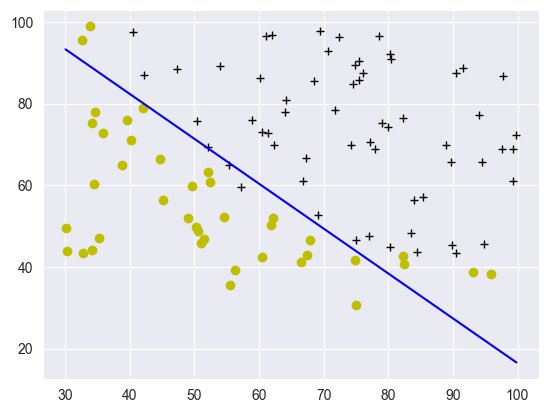

In [23]:
plot_decision_boundary(w, b, X_train, y_train)


### Evaluating logistic regression

We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set. 

- First compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example 
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic 

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [24]:
def predict(X: np.ndarray, w: np.array, b: float) -> float:
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters w

    Args:
		X: Shape (m, n))
		w: Parameters of the model
		b: Parameter of the model

    Returns:
		p: The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape
    p = np.zeros(m)

    for i in range(m):
        z_wb = np.dot(X[i], w)
        for j in range(n):
            z_wb += 0

        z_wb += b
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = 1 if f_wb > 0.5 else 0

    return p


In [25]:
# Test your predict code
np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3
tmp_X = np.random.randn(4, 2) - 0.5

tmp_p = predict(tmp_X, tmp_w, tmp_b)
print(f"Output of predict: shape {tmp_p.shape}, value {tmp_p}")


Output of predict: shape (4,), value [0. 1. 1. 1.]


Now let's use this to compute the accuracy on the training set

In [26]:
# Compute accuracy on our training set
p = predict(X_train, w, b)
print("Train Accuracy: %f" % (np.mean(p == y_train) * 100))


Train Accuracy: 92.000000


## Regularized Logistic Regression

The product manager of the factory has the results for some microchips on two different tests. 
- From these two tests, the manager would like to determine whether the microchips should be accepted or rejected. 
- To help make the decision, the dataset of test results on past microchips are available, from which a logistic regression model can be built.

In [27]:
df = pd.read_csv("data/chips_test.csv")
df.head()


,Chip1,Chip2,pass
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [28]:
X_train, y_train = df.drop("pass", axis=1).to_numpy(), df["pass"].to_numpy()


In [29]:
# print X_train
print("X_train:", X_train[:5])
print("Type of X_train:", type(X_train))

# print y_train
print("y_train:", y_train[:5])
print("Type of y_train:", type(y_train))


X_train: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Type of X_train: <class 'numpy.ndarray'>
y_train: [1 1 1 1 1]
Type of y_train: <class 'numpy.ndarray'>


In [30]:
print("The shape of X_train is: " + str(X_train.shape))
print("The shape of y_train is: " + str(y_train.shape))
print("We have m = %d training examples" % (len(y_train)))


The shape of X_train is: (118, 2)
The shape of y_train is: (118,)
We have m = 118 training examples


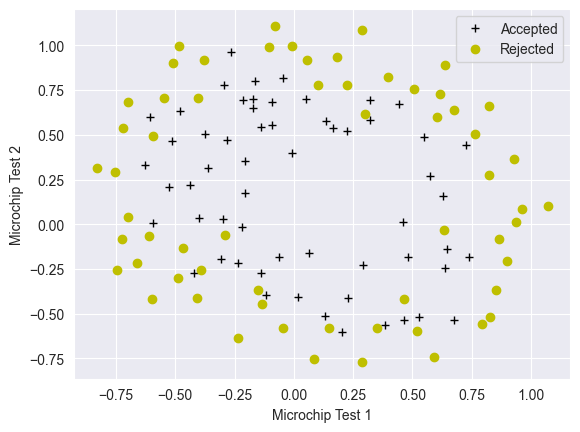

In [31]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="Accepted", neg_label="Rejected")

# Set the y-axis label
plt.ylabel("Microchip Test 2")
# Set the x-axis label
plt.xlabel("Microchip Test 1")
plt.legend(loc="upper right")
plt.show()


### Feature mapping

One way to fit the data better is to create more features from each data point. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 27-dimensional vector. 

- A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will be nonlinear when drawn in our 2-dimensional plot. 

In [32]:
def map_feature(X1, X2):
    """
    Feature mapping function to polynomial features
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j) * (X2**j)))
    return np.stack(out, axis=1)


In [33]:
print("Original shape of data:", X_train.shape)

mapped_X = map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)


Original shape of data: (118, 2)
Shape after feature mapping: (118, 27)


In [34]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])


X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]



### Cost function for regularized logistic regression


For regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Compare this to the cost function without regularization, which is of the form 

$$ J(\mathbf{w}.b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 
Note that the $b$ parameter is not regularized.

Calculate the following term for each element in $w$ 
$$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

In [35]:
def compute_cost_reg(X: np.ndarray, y: np.array, w: np.array, b: float, lambda_: int=1) -> float:
    """
    Computes the cost over all examples
    Args:
      X: data, m examples by n features
      y: target value
      w: Values of parameters of the model
      b: Values of bias parameter of the model
      lambda_: Controls amount of regularization
    Returns:
      total_cost: cost
    """

    m, n = X.shape

    cost_without_reg = compute_cost(X, y, w, b)

    reg_cost = 0.0
    reg_cost = sum(np.square(w))
    total_cost = cost_without_reg + (lambda_ / (2 * m)) * reg_cost

    return total_cost


In [36]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)


Regularized cost : 0.6618252552483948


### Gradient for regularized logistic regression

The gradient of the regularized cost function has two components. The first, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ is a scalar, the other is a vector with the same shape as the parameters $\mathbf{w}$, where the $j^\mathrm{th}$ element is defined as follows:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})$$


Compare this to the gradient of the cost function without regularization (which you implemented above), which is of the form 

$$\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}$$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}$$


As you can see,$\frac{\partial J(\mathbf{w},b)}{\partial b}$ is the same.

In [37]:
def compute_gradient_reg(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float, lambda_: float=1) -> Tuple[float, np.ndarray]:
    """
    Computes the gradient for linear regression

    Args:
      X: variable such as house size
      y: actual value
      w: values of parameters of the model
      b: value of parameter of the model
      lambda_: regularization constant
    Returns
      dj_db: The gradient of the cost w.r.t. the parameter b.
      dj_dw: The gradient of the cost w.r.t. the parameters w.

    """
    m, n = X.shape

    dj_db, dj_dw = compute_gradient(X, y, w, b)
    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_ / m) * w[j]

    return dj_db, dj_dw


In [38]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5

lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(
    f"dj_db: {dj_db}",
)
print(
    f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}",
)


dj_db: 0.07138288792343656
First few elements of regularized dj_dw:
 [-0.010386028450548701, 0.01140985288328012, 0.0536273463274574, 0.003140278267313462]


### Learning parameters using gradient descent

Similar to the previous parts, the gradient descent function can implemented to learn the optimal parameters $w$,$b$. 

In [39]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 1.0

# Set regularization parameter lambda_ to 1 (you can try varying this)
lambda_ = 0.01
# Some gradient descent settings
iterations = 10000
alpha = 0.01

w, b, J_history, _ = gradient_descent(
    X_mapped,
    y_train,
    initial_w,
    initial_b,
    compute_cost_reg,
    compute_gradient_reg,
    alpha,
    iterations,
    lambda_,
)


Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.47   
Iteration 8000: Cost     0.46   
Iteration 9000: Cost     0.45   
Iteration 9999: Cost     0.45   


### Plotting the decision boundary
To help you visualize the model learned by this classifier, the `plot_decision_boundary` function which plots the (non-linear) decision boundary that separates the positive and negative examples can be used. 

- The non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then drew a contour plot of where the predictions change from y = 0 to y = 1.

- After learning the parameters $w$,$b$, the next step is to plot a decision boundary.

/var/folders/63/j6w_zsv155n1r5q96vf1qrwc0000gn/T/ipykernel_49237/2290614261.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i, j] = sig(np.dot(map_feature(u[i], v[j]), w) + b)


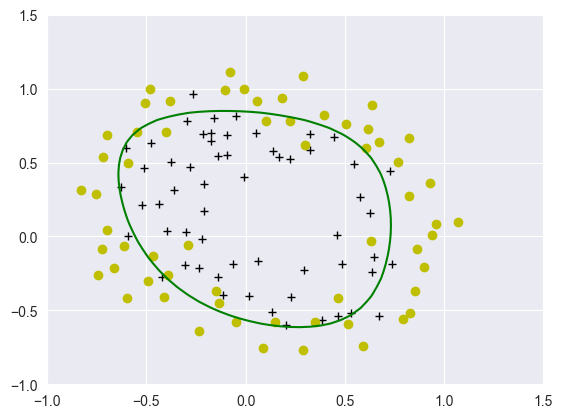

In [40]:
plot_decision_boundary(w, b, X_mapped, y_train)


In [41]:
# Compute accuracy on the training set
p = predict(X_mapped, w, b)

print("Train Accuracy: %f" % (np.mean(p == y_train) * 100))


Train Accuracy: 82.203390
